<a href="https://colab.research.google.com/github/arspen11/gmp_headroom_analysis/blob/main/CM360_Headroom_Analysis_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GMP Headroom Analysis Tool for CM360

This lightweight tool will help you to determine how much additional budget your media buy can accomodate while remaining within your client's performance constraints.

#Step 1: Set up environment



In [ ]:
# @title
# Automatically restart kernel after installs
'''
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)
'''
# data processing libraries
import numpy as np
from numpy.core.numeric import NaN
import datetime
import pandas as pd
import pandas_gbq

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier

# modeling and metrics
from scipy.optimize import least_squares
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

import itertools
from scipy.stats.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20 , 10] #change size of plot
import seaborn as sns
import matplotlib.ticker as ticker

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import iPyWidgets
import ipywidgets as widgets
from IPython.display import display
from IPython.core.display import display, HTML

print('\n\nThis step is now complete. Move on to the next step.')

#Step 2: Load your data



Download a standard offline report from CM360, in a .csv format, with the exact settings below:

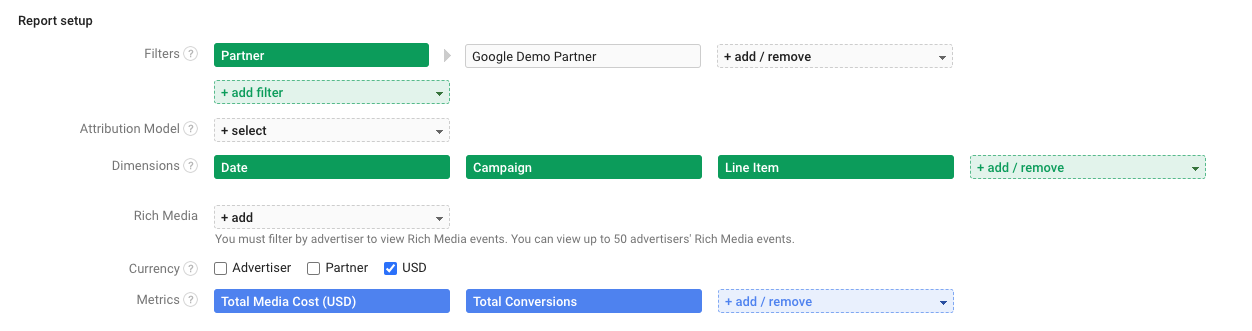

The structure of this .csv file should appear as follow:
```
Date,Campaign,Line Item,Total Media Cost (USD),Total Conversions
2021-01-01, 10000, 300
2021-01-02, 11000, 200
2021-01-03, 14000, 400
```
If you don't have reliable spend data, you may:

1.   Include impressions in lieu of spend
2.   Include impressions in lieu of spend, and provide an estimated average CPM in the cell below.

If you want to use impressions directly without calculating an average spend, set the cell below to "0". Click on the run button once entered.



In [ ]:
average_cpm = 0 #@param {type:"slider", min:0.00, max:50.00, step:0.01}

**One** your data file is ready, choose one of the two options below to load your data into this tool.

##Option 1: Upload .csv file

**Run this cell to upload your CM360 report into this tool:**

In [ ]:
# @title
from google.colab import files

# Upload the CSV file
uploaded = files.upload()

# Get the filename (assumes only one file uploaded)
filename = list(uploaded.keys())[0]

# Print the filename for confirmation
print(f"Uploaded file: {filename}")

df = pd.read_csv(filename)

# Find the index of the last row containing numerical data in all columns
# Find the index of the first row with a null value in the first column
last_data_row = df.index[df.isnull().any(axis=1)].min()

# Select rows up to and including the last data row
df = df.iloc[:last_data_row]

print(df.head())

**Run this cell and select the Line Item that you want to evaluate:**

In [ ]:
# @title
print("Select the Line Item you want to evaluate:")

filtering_line_item = None  # Initialize the global variable

# Extract unique "Line Item" values
unique_line_items = df["Line Item"].unique()
# Sort alphabetically
unique_line_items.sort()

# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=unique_line_items,
    description="Line Item:"
)

def display_selected_line_item(selected_value):  # Use 'selected_value' as the argument name
    global filtering_line_item  # Declare filtering_line_item as global
    filtering_line_item = selected_value  # Update the global variable
    #print("Selected Line Item:", filtering_line_item)

# Create the interactive callback (using 'selected_value' as the argument)
widgets.interact(display_selected_line_item, selected_value=dropdown)

**Run this cell to filter your original file for the Line Item you selected:**

If you need to select a new/different Line Item, simply go back and re-run the
previous cell, and proceed with the tool from here.

In [ ]:
# @title
#Update df with the selected Line Item.
# Filter the DataFrame and select desired columns
filtered_df = df.loc[df["Line Item"] == filtering_line_item]
filtered_df = filtered_df[["Date", "Total Media Cost (USD)", "Total Conversions"]]
# Define the dictionary for renaming columns
new_column_names = {"Date": "date", "Total Media Cost (USD)": "spend", "Total Conversions": "action"}

# Rename the columns using the dictionary
filtered_df = filtered_df.rename(columns=new_column_names)

# Reset the index to the date and drop the duplicative column, nulls and zeros
filtered_df = filtered_df.set_index(filtered_df['date'])
filtered_df = filtered_df.drop(columns = ['date'])
filtered_df = filtered_df.dropna()
filtered_df = filtered_df[filtered_df.spend != 0]
filtered_df = filtered_df[filtered_df.action != 0]

# identify target and feature variables
variables = list(filtered_df.columns)
ycols = 'action'
xcols = 'spend' #[var for var in variables if var not in ycols]

print('\n\nThis step is now complete. Move on to the next step.')

##Option 2: Load .csv from Google Drive

In [ ]:
# @title
# Load Demoverse DV360 report to dataframe
df = pd.read_csv('/content/drive/MyDrive/headroom cpc data.csv')
df['date'] = pd.to_datetime(df['date'])

# Reset the index to the date and drop the duplicative column, nulls and zeros
df = df.set_index(df['date'])
df = df.drop(columns = ['date'])
df = df.dropna()
df = df[df.spend != 0]
df = df[df.action != 0]

# identify target and feature variables
variables = list(df.columns)
ycols = 'action'
xcols = 'spend' #[var for var in variables if var not in ycols]

print('\n\nThis step is now complete. Move on to the next step.')

#Step 3: Fit various curves to your data to find the best fitting trendline

**Run this cell to test various models, and to review scatter plots of each model, as well as their respective r-squared:**

These views represent how closely the model's predicted values match the actual values in the data.

In [ ]:
# @title
# Create 3 separate models, each testing differnt curve shapes

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

models = []

# Model 1: Linear Fit
x1 = filtered_df[xcols].values
x1 = sm.add_constant(x1)
y1 = filtered_df[ycols].values
model1 = sm.OLS(y1, x1).fit()
models.append(model1)

# Model 2: Logarithmic Fit (log x)
x2 = filtered_df[xcols].values
x2 = np.log(x2)
x2 = sm.add_constant(x2)
y2 = filtered_df[ycols].values
model2 = sm.OLS(y2, x2).fit()
models.append(model2)

# Model 3: Exponential (log x)
x3 = filtered_df[xcols].values
x3 = sm.add_constant(x3)
y3 = filtered_df[ycols].values
y3 = np.log(y3)
model3 = sm.OLS(y3, x3).fit()
models.append(model3)

# Show a plot of each model

for i, model in enumerate(models):
    print(f"\n")

    if i == 0:
      print(f"Model 1: Linear Curve\nR-squared: {model.rsquared}")
      plot_x_values = filtered_df[xcols].to_numpy().reshape(-1, 1)
      plot_ones = np.ones((plot_x_values.shape[0], 1))
      plot_x_values = np.hstack((plot_ones, plot_x_values))
      plot_predicted_y = model.predict(plot_x_values)
      plot_title = 'Model 1: Linear Curve'
    elif i == 1:
      print(f"Model 2: Logarithmic Curve\nR-squared: {model.rsquared}")
      plot_x_values = filtered_df[xcols].to_numpy().reshape(-1, 1)
      plot_x_values = np.log(plot_x_values)
      plot_ones = np.ones((plot_x_values.shape[0], 1))
      plot_x_values = np.hstack((plot_ones, plot_x_values))
      plot_predicted_y = model.predict(plot_x_values)
      plot_title = 'Model 2: Logarithmic Curve'
    elif i == 2:
      plot_fitted_values = np.exp(model.fittedvalues)
      print(f"Model 3: Exponential Curve\nR-squared: {model.rsquared}")
      plot_x_values = filtered_df[xcols].to_numpy().reshape(-1, 1)
      #plot_x_values = np.log(plot_x_values)
      plot_ones = np.ones((plot_x_values.shape[0], 1))
      plot_x_values = np.hstack((plot_ones, plot_x_values))
      plot_predicted_y = model.predict(plot_x_values)
      plot_predicted_y = np.exp(plot_predicted_y)
      plot_title = 'Model 3: Exponential Curve'
    else:
      print('error')

    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot scatter on primary axis
    ax1.scatter(filtered_df[xcols], filtered_df[ycols], label="Actual Values")
    ax1.set_xlabel('Spend')
    ax1.set_ylabel('Action')
    ax1.grid(True)

    # Create secondary axis and plot fitted values
    #ax2 = ax1.twinx()
    ax1.plot(filtered_df[xcols], plot_predicted_y, "r.", label="Fitted Values (OLS)", markersize=5)
    ax1.set_ylabel("Fitted Values", color="red")

    # Set title and legend
    plt.title(plot_title)
    plt.legend(loc="upper left")

    xformatter = ticker.FuncFormatter(lambda x, p: f'${x:,.0f}' if abs(x) < 1e3 else f'${x/1e3:,.0f}K' if abs(x) < 1e6 else f'${x/1e6:,.1f}M' if abs(x) < 1e9 else f'${x/1e9:,.1f}B')
    ax1.xaxis.set_major_formatter(xformatter)

    yformatter = ticker.FuncFormatter(lambda x, p: f'${x:,.0f}' if abs(x) < 1e3 else f'{x/1e3:,.0f}K' if abs(x) < 1e6 else f'{x/1e6:,.1f}M' if abs(x) < 1e9 else f'{x/1e9:,.1f}B')
    ax1.yaxis.set_major_formatter(yformatter)

    plt.show()

**Run this cell to review standard summaries of each of the models we tested:**

In [ ]:
# @title
for i, model in enumerate(models):
    if i == 0:
      model_name = "Model 1: Linear Curve"
    elif i == 1:
      model_name = "Model 2: Logarithmic Curve"
    elif i == 2:
      model_name =  "Model 3: Exponential Curve"
    else:
      print('error')
    print(f"\033[1m{model_name}\033[0m {model.summary()}")
    print("\n==============================================================================\n\n\n")

**Run this cell to select the best-fit model based on the highest r-squared value:**

In [ ]:
# @title
# Select model with highest R-squared
best_model = max(models, key=lambda model: model.rsquared)
print(best_model)
print(f"Best model R-squared: {best_model.rsquared}")
#print(best_model.summary())
if best_model == models[0]:
  print('Your best fitting model is Model 1, using a linear curve.')
if best_model == models[1]:
  print('Your best fitting model is Model 2, using a logarithmic curve.')
if best_model == models[2]:
  print('Your best fitting model is Model 3, using an exponential curve.')

**If you want to proceed with the optimization using the best fitting model that was already selected, skip the following slide. If you want to override the suggested model and select a different model to use, run this cell and make your selection below:**

In [ ]:
# @title
override_optimizing_model = None  # Initialize the global variable

model_options = [
    ("Model 1: Linear Curve", model1),  # Friendly name, underlying value
    ("Model 2: Logarithmic Curve", model2),
    ("Model 3: Exponential Curve", model3)
]

# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=model_options,
    description="Models:"
)

def display_models(selected_value):  # Use 'selected_value' as the argument name
    global override_optimizing_model  # Declare filtering_line_item as global
    override_optimizing_model = selected_value  # Update the global variable
    global best_model
    best_model = override_optimizing_model
    #print("Selected Line Item:", filtering_line_item)

# Create the interactive callback (using 'selected_value' as the argument)
widgets.interact(display_models, selected_value=dropdown)

# Step 5: Find your optimal daily budget and export the model predictions

**Set your target CPA to find the maximum dialy budget your media buy can accomodate:**

In [ ]:
target_cpa = 20 #@param {type:"slider", min:0.50, max:500.00, step:0.50}

In [ ]:
#Run predictions on array of x valus in 10 dollar increments.

if best_model == model1:
  #print('\nlinear')
  optimize_x_values = np.arange(10, max(filtered_df[xcols])*3, 10).reshape(-1, 1)
  optimize_ones = np.ones((optimize_x_values.shape[0], 1))
  optimize_x_values = np.hstack((optimize_ones, optimize_x_values))
  optimize_predicted_y = best_model.predict(optimize_x_values)
  #print(optimize_predicted_y)
elif best_model == model2:
  #print('\nlogarithmic')
  optimize_x_values = np.arange(10, max(filtered_df[xcols])*3, 10).reshape(-1, 1)
  optimize_x_values = np.log(optimize_x_values)
  optimize_ones = np.ones((optimize_x_values.shape[0], 1))
  optimize_x_values = np.hstack((optimize_ones, optimize_x_values))
  optimize_predicted_y = best_model.predict(optimize_x_values)
  #print(optimize_predicted_y)
elif best_model == model3:
  #print('\nexponential')
  optimize_x_values = np.arange(10, max(filtered_df[xcols])*3, 10).reshape(-1, 1)
  optimize_ones = np.ones((optimize_x_values.shape[0], 1))
  optimize_x_values = np.hstack((optimize_ones, optimize_x_values))
  optimize_predicted_y = best_model.predict(optimize_x_values)
  optimize_predicted_y = np.exp(optimize_predicted_y)
  #print(optimize_predicted_y)
else:
  print('error')

# @title
# Calculate CTR by multiplying x*y
optimize_predicted_cpa = optimize_predicted_y / optimize_x_values[0:,1]

# Find the highest value of x where cpa is less than or equal to the target cpa.
highest_x = np.max(optimize_x_values[0:,1][np.where(optimize_predicted_cpa < target_cpa)])
print(f"You can spend up to the following amount per day for the remainder of \nyour media buy while staying under your Cost per Action of goal of ${target_cpa}. \n")
print(f"${highest_x}")

**Execute this cell to download a Google Sheet with the full predicted return curve based on your best model for additional scenario planning:**

In [ ]:
# @title
df_range = pd.DataFrame({'spend': optimize_x_values[:, 1].reshape(-1), 'predicted action': optimize_predicted_y.reshape(-1), 'predicted_cpa': optimize_predicted_cpa.reshape(-1)})
df_range

# prompt: export df_range as csv
df_range.to_csv('/content/drive/MyDrive/df_range.csv')

print("A .csv file has been exported to your Google Drive.\n")

print(df_range)
